#**Import Libraries and Download Data**

In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
from warnings import simplefilter
from hyperopt import fmin, tpe, hp, space_eval, Trials
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go

# Mute sklearn warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Download stock price data
data = yf.download("THETA-USD", start="2022-01-01", end="2024-01-01")

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head

<bound method NDFrame.head of                 Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2022-01-01  4.715386  4.946453  4.712864  4.946453   4.946453  111568121
2022-01-02  4.946442  4.946442  4.798754  4.885483   4.885483  120684888
2022-01-03  4.886138  4.887075  4.628585  4.705298   4.705298  138983217
2022-01-04  4.707325  4.939673  4.600673  4.747562   4.747562  187468379
2022-01-05  4.746508  5.232969  4.220721  4.430466   4.430466  418685964
...              ...       ...       ...       ...        ...        ...
2023-12-27  1.412128  1.422967  1.298134  1.351071   1.351071   45676395
2023-12-28  1.351224  1.413116  1.274219  1.339019   1.339019   57196107
2023-12-29  1.338838  1.338838  1.252202  1.274493   1.274493   35455643
2023-12-30  1.274710  1.366284  1.253968  1.253968   1.253968   39620536
2023-12-31  1.254099  1.300568  1.238005  1.250499   1.250499   23981518

[730 rows x 6 column

In [4]:
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [5]:
print(data.shape)

(730, 6)


In [6]:
data.iloc[:, 0:-2].describe()

,Open,High,Low,Close
count,730.000000,730.000000,730.000000,730.000000
mean,1.385460,1.436379,1.331010,1.380672
std,0.942354,0.989035,0.893490,0.934269
min,0.564798,0.585708,0.563040,0.564645
25%,0.828568,0.845314,0.798620,0.828697
50%,1.056123,1.088422,1.026080,1.056195
75%,1.285099,1.347425,1.221448,1.281703
max,4.946442,5.232969,4.798754,4.946453


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2022-01-01 to 2023-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       730 non-null    float64
 1   High       730 non-null    float64
 2   Low        730 non-null    float64
 3   Close      730 non-null    float64
 4   Adj Close  730 non-null    float64
 5   Volume     730 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 39.9 KB


In [8]:
#Normalisasi Data : Min-Max Scaler

close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [9]:
# Extract original and scaled close prices
original_close_prices = data['Close'].values
scaled_close_prices = scaled_data.flatten()

# Calculate statistics
original_stats = pd.Series(original_close_prices).describe()
scaled_stats = pd.Series(scaled_close_prices).describe()

# Print the summary
print("Original Close Prices Statistics:")
print(original_stats)

print("\nScaled Close Prices Statistics:")
print(scaled_stats)


Original Close Prices Statistics:
count    730.000000
mean       1.380672
std        0.934269
min        0.564645
25%        0.828697
50%        1.056195
75%        1.281703
max        4.946453
dtype: float64

Scaled Close Prices Statistics:
count    730.000000
mean       0.186231
std        0.213215
min        0.000000
25%        0.060261
50%        0.112180
75%        0.163644
max        1.000000
dtype: float64


In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plot all prices
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index, y=data['Open'], mode='lines', name='Opening Price', line=dict(color='red')))
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Closing Price', line=dict(color='green')))
fig.add_trace(go.Scatter(x=data.index, y=data['Low'], mode='lines', name='Low Price', line=dict(color='black')))
fig.add_trace(go.Scatter(x=data.index, y=data['High'], mode='lines', name='High Price', line=dict(color='blue')))

fig.update_layout(
    title='Stock Price History',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Stock Price'),
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
)

# Plot subplots for each individual price
fig_subplots = make_subplots(rows=2, cols=2, subplot_titles=('Opening Price', 'Closing Price', 'Low Price', 'High Price'))

fig_subplots.add_trace(go.Scatter(x=data.index, y=data['Open'], mode='lines', name='Opening Price', line=dict(color='red')), row=1, col=1)
fig_subplots.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Closing Price', line=dict(color='green')), row=1, col=2)
fig_subplots.add_trace(go.Scatter(x=data.index, y=data['Low'], mode='lines', name='Low Price', line=dict(color='black')), row=2, col=1)
fig_subplots.add_trace(go.Scatter(x=data.index, y=data['High'], mode='lines', name='High Price', line=dict(color='blue')), row=2, col=2)

fig_subplots.update_layout(title='Stock Price Subplots', showlegend=False)

fig.show()
fig_subplots.show()

#**Data Preprocessing and Preparation**

In [11]:
# Data preparation
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        lag_values = data[i:(i + n_steps), 0]
        X.append(np.concatenate([lag_values, [data[i + n_steps, 0]]]))
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 120
X, y = prepare_data(scaled_data, n_steps)

# Splitting into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM and GRU models
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


#**Hyperparameter Tuning**

In [12]:
# Define hyperparameter search space
space = {
    'units': hp.choice('units', [50, 100, 150]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning rate', np.log(0.001), np.log(0.01)),
    'epochs': hp.choice('epochs', [50, 100, 150]),
    'batch_size': hp.choice('batch_size', [32, 64, 128])
}

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


#**Model Building and Training**

In [13]:
# Create a function to build and train the model with hyperparameters
from tensorflow.keras.optimizers import Adamax

def objective(params, model_type, X_train, y_train, X_test, y_test):
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))
    elif model_type == 'gru':
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))

    model.compile(optimizer=Adamax(learning_rate=params['learning_rate']), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'],
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_orig, y_pred)
    return mse, history

# Set up the Trials object to keep track of the optimization process
trials_lstm = Trials()
trials_gru = Trials()

# Use the fmin function for Bayesian optimization for LSTM and GRU
best_lstm = fmin(fn=lambda params: objective(params, 'lstm', X_train_lstm, y_train, X_test_lstm, y_test)[0],
                 space=space, algo=tpe.suggest, max_evals=20, trials=trials_lstm)

best_gru = fmin(fn=lambda params: objective(params, 'gru', X_train_gru, y_train, X_test_gru, y_test)[0],
                space=space, algo=tpe.suggest, max_evals=20, trials=trials_gru)

# Get the best hyperparameters from the optimization results
best_params_lstm = space_eval(space, best_lstm)
best_params_gru = space_eval(space, best_gru)


4/4 [==============================] - 1s 11ms/step

4/4 [==============================] - 1s 12ms/step

4/4 [==============================] - 1s 11ms/step

4/4 [==============================] - 1s 13ms/step

4/4 [==============================] - 1s 10ms/step

4/4 [==============================] - 1s 10ms/step

4/4 [==============================] - 1s 13ms/step

4/4 [==============================] - 1s 10ms/step

4/4 [==============================] - 1s 12ms/step

4/4 [==============================] - 1s 12ms/step

4/4 [==============================] - 1s 11ms/step

4/4 [==============================] - 1s 10ms/step

4/4 [==============================] - 1s 11ms/step

4/4 [==============================] - 1s 10ms/step

4/4 [==============================] - 1s 9ms/step

4/4 [==============================] - 1s 13ms/step

4/4 [==============================] - 1s 10ms/step

4/4 [==============================] - 1s 14ms/step

4/4 [==============================] - 1s 14ms/

#**Final Model and History Plot**

In [14]:
# Build the final LSTM model using the best hyperparameters
final_model_lstm = Sequential([
    LSTM(units=best_params_lstm['units'], return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=best_params_lstm['units'], return_sequences=True),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=best_params_lstm['units']),
    Dense(units=1)
])

final_model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_lstm['learning_rate']),
                         loss='mean_squared_error')

# Train the final LSTM model
history_lstm = final_model_lstm.fit(X_train_lstm, y_train, epochs=best_params_lstm['epochs'],
                                    batch_size=best_params_lstm['batch_size'], verbose=2,
                                    validation_split=0.1, callbacks=[early_stopping])

# Build the final GRU model using the best hyperparameters
final_model_gru = Sequential([
    GRU(units=best_params_gru['units'], return_sequences=True, input_shape=(X_train_gru.shape[1], 1)),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=best_params_gru['units'], return_sequences=True),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=best_params_gru['units']),
    Dense(units=1)
])

final_model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_gru['learning_rate']),
                        loss='mean_squared_error')

# Train the final GRU model
history_gru = final_model_gru.fit(X_train_gru, y_train, epochs=best_params_gru['epochs'],
                                  batch_size=best_params_gru['batch_size'], verbose=2,
                                  validation_data=(X_test_gru, y_test), callbacks=[early_stopping])


Epoch 1/150
14/14 - 6s - loss: 0.0040 - val_loss: 0.0037 - 6s/epoch - 417ms/step
Epoch 2/150
14/14 - 0s - loss: 0.0014 - val_loss: 5.6634e-04 - 260ms/epoch - 19ms/step
Epoch 3/150
14/14 - 0s - loss: 7.6840e-04 - val_loss: 4.1728e-04 - 237ms/epoch - 17ms/step
Epoch 4/150
14/14 - 0s - loss: 7.2296e-04 - val_loss: 4.6234e-04 - 260ms/epoch - 19ms/step
Epoch 5/150
14/14 - 0s - loss: 6.6750e-04 - val_loss: 2.9578e-04 - 244ms/epoch - 17ms/step
Epoch 6/150
14/14 - 0s - loss: 5.6950e-04 - val_loss: 1.2608e-04 - 255ms/epoch - 18ms/step
Epoch 7/150
14/14 - 0s - loss: 5.8118e-04 - val_loss: 6.5952e-05 - 254ms/epoch - 18ms/step
Epoch 8/150
14/14 - 0s - loss: 5.7904e-04 - val_loss: 3.7827e-04 - 261ms/epoch - 19ms/step
Epoch 9/150
14/14 - 0s - loss: 5.2191e-04 - val_loss: 2.0870e-04 - 335ms/epoch - 24ms/step
Epoch 10/150
14/14 - 0s - loss: 4.9542e-04 - val_loss: 5.2426e-04 - 334ms/epoch - 24ms/step
Epoch 11/150
14/14 - 0s - loss: 6.6166e-04 - val_loss: 6.0205e-05 - 345ms/epoch - 25ms/step
Epoch 12/15

#**Evaluasi Model dan Visualisasi**

4/4 [==============================] - 1s 16ms/step
Performance Metrics for LSTM:
Mean Squared Error (MSE): 0.00017262927333230085
Root Mean Squared Error (RMSE): 0.013138845966533775
Mean Absolute Percentage Error (MAPE): 1.100639660520166
Mean Absolute Deviation (MAD): 0.009517150824187231
4/4 [==============================] - 1s 12ms/step
Performance Metrics for GRU:
Mean Squared Error (MSE): 1.2615330012447222e-05
Root Mean Squared Error (RMSE): 0.003551806584323986
Mean Absolute Percentage Error (MAPE): 0.3170163805011586
Mean Absolute Deviation (MAD): 0.0027074388793257432


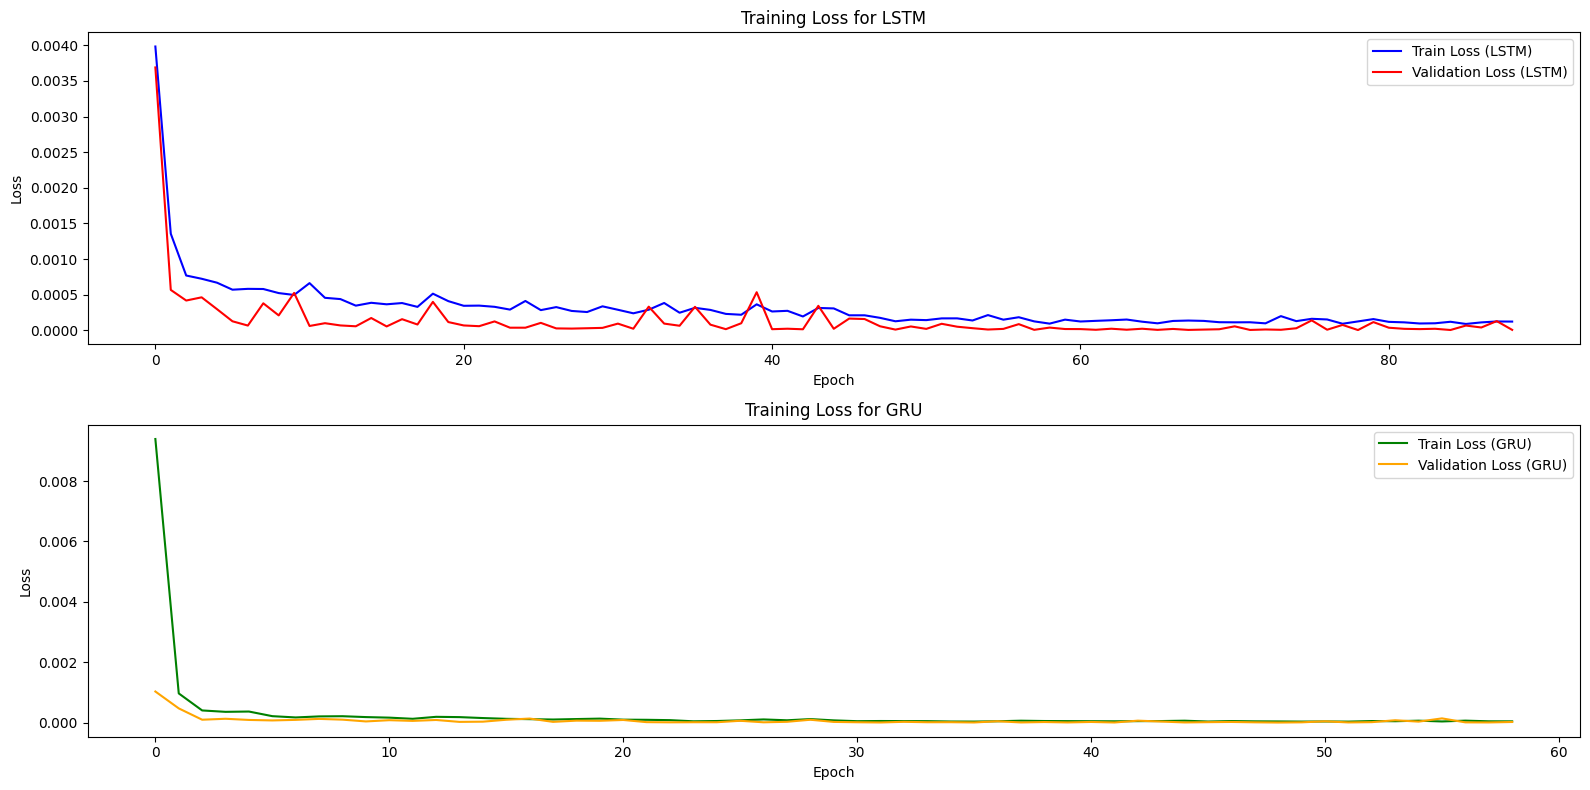

In [15]:
# Model evaluation for LSTM
y_pred_lstm = final_model_lstm.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_orig_lstm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for LSTM
mse_lstm = mean_squared_error(y_test_orig_lstm, y_pred_lstm)
rmse_lstm = math.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((y_test_orig_lstm - y_pred_lstm) / y_test_orig_lstm)) * 100
mad_lstm = mean_absolute_error(y_test_orig_lstm, y_pred_lstm)

# Display results for LSTM
print("Performance Metrics for LSTM:")
print("Mean Squared Error (MSE):", mse_lstm)
print("Root Mean Squared Error (RMSE):", rmse_lstm)
print("Mean Absolute Percentage Error (MAPE):", mape_lstm)
print("Mean Absolute Deviation (MAD):", mad_lstm)

# Model evaluation for GRU
y_pred_gru = final_model_gru.predict(X_test_gru)
y_pred_gru = scaler.inverse_transform(y_pred_gru)
y_test_orig_gru = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for GRU
mse_gru = mean_squared_error(y_test_orig_gru, y_pred_gru)
rmse_gru = math.sqrt(mse_gru)
mape_gru = np.mean(np.abs((y_test_orig_gru - y_pred_gru) / y_test_orig_gru)) * 100
mad_gru = mean_absolute_error(y_test_orig_gru, y_pred_gru)

# Display results for GRU
print("Performance Metrics for GRU:")
print("Mean Squared Error (MSE):", mse_gru)
print("Root Mean Squared Error (RMSE):", rmse_gru)
print("Mean Absolute Percentage Error (MAPE):", mape_gru)
print("Mean Absolute Deviation (MAD):", mad_gru)

# Visualize predictions for the final LSTM model
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                         y=y_test_orig_lstm.flatten(),
                         mode='lines',
                         name="Actual Stock Prices",
                         line=dict(color='blue')))

fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                         y=y_pred_lstm.flatten(),
                         mode='lines',
                         name="Predicted Stock Prices (LSTM)",
                         line=dict(color='red')))


# Visualize predictions for the final GRU model
fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                         y=y_pred_gru.flatten(),
                         mode='lines',
                         name="Predicted Stock Prices (GRU)",
                         line=dict(color='orange')))

fig.update_layout(title="Stock Price Prediction (LSTM vs GRU)",
                  xaxis_title="Date",
                  yaxis_title="Stock Price (IDR)",
                  template='plotly_dark')

fig.show()

# Plot training history using Matplotlib
plt.figure(figsize=(16, 8))

# Plot training loss for LSTM
plt.subplot(2, 1, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss (LSTM)', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='red')
plt.title('Training Loss for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training loss for GRU
plt.subplot(2, 1, 2)
plt.plot(history_gru.history['loss'], label='Train Loss (GRU)', color='green')
plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='orange')
plt.title('Training Loss for GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok

In [ ]:
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import mean_squared_error
import math
from hyperopt import fmin, tpe, hp, space_eval, Trials
from tensorflow.keras.callbacks import EarlyStopping
from pyngrok import ngrok
import plotly.graph_objects as go

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Streamlit app
def main():
    st.title("Stock Price Prediction App")

    # Download stock price data
    st.sidebar.header("Data Download")
    stock_symbol = st.sidebar.text_input("Enter Stock Symbol (e.g., BBCA.JK):", "BBCA.JK")
    start_date = st.sidebar.date_input("Start Date", pd.to_datetime("2019-01-01"))
    end_date = st.sidebar.date_input("End Date", pd.to_datetime("2023-01-01"))

    data = yf.download(stock_symbol, start=start_date, end=end_date)

    # Data preprocessing
    close_prices = data['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_prices)

    # Data preparation
    n_steps = st.sidebar.slider("Select Number of Time Steps:", min_value=10, max_value=300, value=120, step=10)
    X, y = prepare_data(scaled_data, n_steps)

    # Splitting into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape data for LSTM and GRU models
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Sidebar for hyperparameter tuning
    st.sidebar.header("Hyperparameter Tuning")
    units = st.sidebar.selectbox("Select Number of Units:", [50, 100, 150], index=1)
    dropout_rate = st.sidebar.slider("Select Dropout Rate:", min_value=0.2, max_value=0.5, value=0.4, step=0.01)
    learning_rate = st.sidebar.slider("Select Learning Rate:", np.log(0.001), np.log(0.01), value=np.log(0.005), step=0.001)
    epochs = st.sidebar.selectbox("Select Number of Epochs:", [50, 100, 150], index=1)
    batch_size = st.sidebar.selectbox("Select Batch Size:", [32, 64, 128], index=1)

    # Hyperparameter search space
    space = {
        'units': units,
        'dropout_rate': dropout_rate,
        'learning_rate': np.exp(learning_rate),
        'epochs': epochs,
        'batch_size': batch_size
    }

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Run hyperparameter optimization
    best_params_lstm, history_lstm, y_pred_lstm, y_test_orig_lstm = run_optimization(space, 'lstm', X_train_lstm, y_train, X_test_lstm, y_test, scaler, early_stopping)
    best_params_gru, history_gru, y_pred_gru, y_test_orig_gru = run_optimization(space, 'gru', X_train_gru, y_train, X_test_gru, y_test, scaler, early_stopping)

    # Display results
    st.header("Results for LSTM Model")
    display_results(best_params_lstm, history_lstm, y_test_orig_lstm, y_pred_lstm)

    st.header("Results for GRU Model")
    display_results(best_params_gru, history_gru, y_test_orig_gru, y_pred_gru)

    # Visualize predictions for the final LSTM model
    st.header("Visualize Predictions (LSTM)")
    visualize_predictions(data, train_size, n_steps, y_test_orig_lstm, y_pred_lstm)

    # Visualize predictions for the final GRU model
    st.header("Visualize Predictions (GRU)")
    visualize_predictions(data, train_size, n_steps, y_test_orig_gru, y_pred_gru)

    # Plot training history using Matplotlib
    st.header("Training History")
    plot_training_history(history_lstm, history_gru)


def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        lag_values = data[i:(i + n_steps), 0]
        X.append(np.concatenate([lag_values, [data[i + n_steps, 0]]]))
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)


def run_optimization(space, model_type, X_train, y_train, X_test, y_test, scaler, early_stopping):
    # Set up the Trials object to keep track of the optimization process
    trials = Trials()

    # Use the fmin function for Bayesian optimization
    best_params = fmin(fn=lambda params: objective(params, model_type, X_train, y_train, X_test, y_test, scaler, early_stopping),
                      space=space, algo=tpe.suggest, max_evals=20, trials=trials)

    # Get the best hyperparameters from the optimization results
    best_params = space_eval(space, best_params)

    # Build the final model using the best hyperparameters
    final_model = build_model(best_params, model_type, X_train)

    # Train the final model
    history = final_model.fit(X_train, y_train,
                              epochs=best_params['epochs'],
                              batch_size=best_params['batch_size'],
                              verbose=2,
                              validation_split=0.1,
                              callbacks=[early_stopping])

    # Model evaluation
    y_pred = final_model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    return best_params, history, y_pred, y_test_orig


def build_model(params, model_type, X_train):
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))
    elif model_type == 'gru':
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))

    model.compile(optimizer=Adamax(learning_rate=params['learning_rate']), loss='mean_squared_error')
    return model


def objective(params, model_type, X_train, y_train, X_test, y_test, scaler, early_stopping):
    # Build and train the model
    final_model = build_model(params, model_type, X_train)
    history = final_model.fit(X_train, y_train,
                              epochs=params['epochs'],
                              batch_size=params['batch_size'],
                              verbose=0,
                              validation_split=0.1,
                              callbacks=[early_stopping])

    # Model evaluation
    y_pred = final_model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate and return mean squared error
    mse = mean_squared_error(y_test_orig, y_pred)
    return mse


def display_results(best_params, history, y_test_orig, y_pred):
    mse = mean_squared_error(y_test_orig, y_pred)
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs((y_test_orig - y_pred) / y_test_orig)) * 100

    st.write("Best Hyperparameters:", best_params)
    st.write("Mean Squared Error (MSE):", mse)
    st.write("Root Mean Squared Error (RMSE):", rmse)
    st.write("Mean Absolute Percentage Error (MAPE):", mape)

    # Plot training loss
    st.line_chart(pd.DataFrame({'Train Loss': history.history['loss'], 'Validation Loss': history.history['val_loss']}))


def visualize_predictions(data, train_size, n_steps, y_test_orig, y_pred):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                             y=y_test_orig.flatten(),
                             mode='lines',
                             name="Actual Stock Prices",
                             line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                             y=y_pred.flatten(),
                             mode='lines',
                             name="Predicted Stock Prices",
                             line=dict(color='red')))

    fig.update_layout(title="Stock Price Prediction",
                      xaxis_title="Date",
                      yaxis_title="Stock Price (IDR)",
                      template='plotly_dark')

    st.plotly_chart(fig)


def plot_training_history(history_lstm, history_gru):
    plt.figure(figsize=(16, 8))

    # Plot training loss for LSTM
    plt.subplot(2, 1, 1)
    plt.plot(history_lstm.history['loss'], label='Train Loss (LSTM)', color='blue')
    plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='red')
    plt.title('Training Loss for LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training loss for GRU
    plt.subplot(2, 1, 2)
    plt.plot(history_gru.history['loss'], label='Train Loss (GRU)', color='green')
    plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='orange')
    plt.title('Training Loss for GRU')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    st.pyplot()

if __name__ == "__main__":
    main()

2024-01-20 09:29:32.659 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
[*********************100%%**********************]  1 of 1 completed

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 9ms/step

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 1s 9ms/step

6/6 [==============================] - 1s 9ms/step

6/6 [==============================] - 1s 9ms/step

6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 1s 9ms/step

6/6 [==============================] - 1s 17ms/step

6/6 [==============================] - 1s 16ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 1s 9ms/step

6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 1s 10ms/step

6/6

NameError: name 'plt' is not defined

In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.476s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


In [ ]:
!streamlit run app.py &>/dev/null&

In [ ]:
from pyngrok import ngrok
# Setup a tunnel to the streamlit port 8501
public_url = ngrok.connect(port='8501')
public_url

ERROR:pyngrok.process.ngrok:t=2024-01-20T09:16:31+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=4d14e8f74c15 err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-01-20T09:16:31+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [ ]:
!streamlit run app.py &>/content/logs.txt &

In [ ]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 34.91.185.94


In [ ]:
!npx localtunnel --port 8501

npx: installed 22 in 1.644s
your url is: https://four-oranges-grab.loca.lt
/root/.npm/_npx/101898/lib/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:43929 (check your firewall settings)
    at Socket.<anonymous> (/root/.npm/_npx/101898/lib/node_modules/localtunnel/lib/TunnelCluster.js:52:11)
    at Socket.emit (events.js:315:20)
    at emitErrorNT (internal/streams/destroy.js:106:8)
    at emitErrorCloseNT (internal/streams/destroy.js:74:3)
    at processTicksAndRejections (internal/process/task_queues.js:80:21)


In [ ]:
!streamlit run app.py --server.address=localhost &>/content/logs.txt &

In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.91.185.94


In [ ]:
from google.colab import files

# Save the final LSTM model
final_model_lstm.save("final_model_lstm.h5")

# Download the saved LSTM model
files.download("final_model_lstm.h5")

# Save the final GRU model
final_model_gru.save("final_model_gru.h5")

# Download the saved GRU model
files.download("final_model_gru.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>